# Visualize speed-dependent locomotion results

### Brandon Pratt, Updated 04/24/2023

Goal: visualize kinematic parameters as a function of walking speed and heading angle

### import python libraries

In [2]:
# python libraries
import os
from os import listdir
from os.path import isfile, join
import math

%matplotlib inline
import matplotlib.pyplot as plt
import ptitprince as pt
import matplotlib.colors as colors
import matplotlib.patches as  mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sea
from scipy import interpolate
from scipy.stats import vonmises
from scipy.stats import iqr
from scipy.stats import mode
from scipy import stats
from scipy.stats import norm, lognorm, gamma, powerlaw, pearsonr
from sklearn.metrics import r2_score
from matplotlib.cbook import boxplot_stats


### load kinematic results

#### Load in Linear Treadmill data

In [3]:
genotype = 'wt_berlin'
genotype_plot_name = 'wt_berlin'

results_dir = 'C:/Users/pratt/Desktop/Analysis/LINEAR_BELT_RESULTS/results/'


figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/LINEAR_BELT_RESULTS/figures/'+ genotype_plot_name+'/'

# meta variables
meta_matrix = np.load(results_dir + genotype + '_meta_matrix.npy', allow_pickle=True)
beh_class = np.load(results_dir + genotype + '_behavior_classification.npy', allow_pickle=True)
heading_angle = np.load(results_dir + genotype + '_heading_angle.npy', allow_pickle=True)
parallel_vel = np.load(results_dir + genotype + '_parallel_velocity.npy', allow_pickle=True)
body_height_walking = np.load(results_dir + genotype + '_body_height_walking.npy', allow_pickle=True)
step_distance = np.load(results_dir + genotype + '_step_distance.npy', allow_pickle=True)
step_freq = np.load(results_dir + genotype + '_step_frequency.npy', allow_pickle=True)
stance_duration = np.load(results_dir + genotype + '_stance_duration.npy', allow_pickle=True)
swing_duration = np.load(results_dir + genotype + '_swing_duration.npy', allow_pickle=True) 
phase = np.load(results_dir + genotype + '_phase.npy', allow_pickle=True)
nlegs_stance_walking = np.load(results_dir + genotype + '_number_legs_in_stance_walking.npy', allow_pickle=True)


### Speed-dependent body kinematics

In [4]:
driving_speeds = np.unique(meta_matrix[:, 2]).tolist()
flies = np.unique(meta_matrix[:, 0]).astype(int).tolist()#[0:10]
walking_speed_dists = []
walking_speed_stats = np.zeros((len(flies), len(driving_speeds))) 
d_cnt = -1
for j in driving_speeds:
    d_cnt += 1
    for fly in flies:
        fly_idxs = meta_matrix[:, 0] == fly
        driving_speed_idxs = meta_matrix[:, 2] == j
        trial_idxs = np.logical_and.reduce((fly_idxs, driving_speed_idxs))
        
        # velocities and forward walking
        vels = parallel_vel[trial_idxs,:].flatten()
        beh_ids = beh_class[trial_idxs, :].flatten()
        
        fw_vels = vels[beh_ids==1]
        
        # filter our nans
        filt_fw_vels = fw_vels[~np.isnan(fw_vels)]
        
        # compute stats
        walking_speed_stats[fly-1, d_cnt] = np.nanmedian(filt_fw_vels)
        
        # store distribution data
        if fly ==1:
            vel_dist = filt_fw_vels
        else:
            vel_dist = np.concatenate((vel_dist, filt_fw_vels))
            
    walking_speed_dists.append(vel_dist)
        

C:\Users\pratt\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


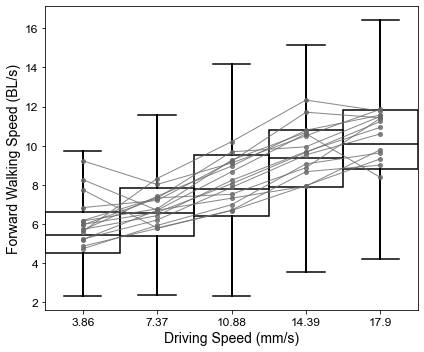

In [5]:
# plot driving speed by walking speed
fig = plt.figure(1, figsize = [6,5])
# plot box plot
sea.boxplot(data = walking_speed_dists, color = "black", width = 1, zorder = 1,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":1},\
showfliers=False, whiskerprops = {'linewidth':2, "zorder":1},\
saturation = 1)

for j in range(walking_speed_stats.shape[0]):
    plt.plot(np.arange(0,len(driving_speeds)), walking_speed_stats[j,:], color ='dimgray', marker='.', markersize = 8, linewidth = 1, alpha = 0.8)
    
# axis properties
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(len(driving_speeds)), np.array(driving_speeds).astype(str), fontsize = 12, rotation = 0, fontname="Arial")
plt.xlabel('Driving Speed (mm/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'driving_walking_speed'+'.png', dpi = 200)
fig.savefig(figure_dir + 'driving_walking_speed'+'.pdf', dpi = 200)

#### 2D pdf of heading angle and forward walking speed

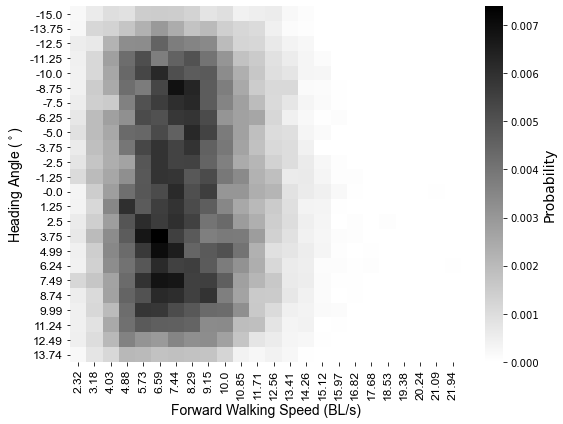

In [6]:
# body kinematics
speed_dist = parallel_vel[meta_matrix[:,0] <20,:].flatten() # only look at a subset of flies
heading_angle_dist = heading_angle[meta_matrix[:,0] <20,:].flatten()
beh_ids = beh_class[meta_matrix[:,0] <20,:].flatten()

# isolate forward walking
fw_heading = heading_angle_dist[beh_ids==1]
fw_vel = speed_dist[beh_ids==1]

# edges of distributions
vel_bins = 25
heading_bins = 25
vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
heading_grid = np.linspace(np.min(fw_heading), np.max(fw_heading), heading_bins)
heading_center = np.around(heading_grid[1::] - (heading_grid[1]-heading_grid[0]),2)

vel_heading_dist = np.zeros((len(heading_center), len(vel_center)))
for j in range(len(heading_center)):
    heading_class = np.logical_and(fw_heading>=heading_grid[j], fw_heading<=heading_grid[j+1])
    
    for i in range(len(vel_center)):
        vel_class = np.logical_and(fw_vel>=vel_grid[i], fw_vel<=vel_grid[i+1])
        vel_heading_dist[j,i] = len(np.where(np.logical_and.reduce((heading_class, vel_class))==True)[0])

vel_heading_dist = vel_heading_dist/np.sum(vel_heading_dist)

# plot 2D distribution  
fig = plt.figure(1, figsize = [8,6])
# ax = sea.heatmap(vel_heading_dist, xticklabels = heading_center, yticklabels=vel_center, cmap='binary')
ax = sea.heatmap(vel_heading_dist, yticklabels = heading_center, xticklabels=vel_center, cmap='binary')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label = 'Probability', size=14)
plt.xlabel('Forward Walking Speed (BL/s)', fontsize =14, fontname = 'Arial')
plt.ylabel('Heading Angle ($^\circ$)', fontsize =14, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'heading_speed_dist'+'.png', dpi = 200)
fig.savefig(figure_dir + 'heading_speed_dist'+'.pdf', dpi = 200)

#### 1D body kinematics, posture, and interlimb coordination 

In [7]:
def one_dimensional_metrics(metric, w_vel, meta_matrix, beh_class):
    dist_cnt = 0
    for fly in np.unique(meta_matrix[:, 0]).astype(int).tolist(): #[0:10]: #[0:10] - select the data of the first 10 flies
        trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]

        # extract data
        vel_data = w_vel[trial_idxs,:].flatten()
        metric_data = metric[trial_idxs,:].flatten() # doesn't need to be transposed

        # behavior classifier
        beh_ids = beh_class[trial_idxs, :].flatten()

        # filter for forward walking behavior == 1
        fw_vel_data = vel_data[beh_ids==1]
        fw_metric_data = metric_data[beh_ids==1]

        # filter concatenated data to remove Nans
        filter_vels = fw_vel_data[~np.isnan(fw_metric_data)]
        filter_data  = fw_metric_data[~np.isnan(fw_metric_data)]

        # filter out -1 values
        filter_vels = filter_vels[~(filter_data ==-1)]
        filter_data = filter_data[~(filter_data ==-1)]
        
        # filter out zero values
        filter_vels = filter_vels[~(filter_data ==0)]
        filter_data = filter_data[~(filter_data ==0)]

        # if there are a sufficient number of steps then store data as a distribution
        if dist_cnt == 0:
            data_dist = filter_data
            vel_dist = filter_vels
            fly_dist = fly*np.ones(len(filter_data))
            dist_cnt = 1
        else:
            data_dist = np.concatenate((data_dist, filter_data))
            vel_dist = np.concatenate((vel_dist, filter_vels))
            fly_dist = np.concatenate((fly_dist, fly*np.ones(len(filter_data))))

    # stack data
    all_data = np.vstack((fly_dist, vel_dist, data_dist))
    
    return all_data

In [8]:
# get distribution data
w_vel = parallel_vel

# ALL 1D kinemtic, coordination, and posture parameters
body_height_dist = one_dimensional_metrics(-body_height_walking, w_vel, meta_matrix, beh_class)
nlegs_stance_dist = one_dimensional_metrics(nlegs_stance_walking, w_vel, meta_matrix, beh_class)

In [9]:
# Plots with marginal distrbutions added
def plot_1D_metrics_marginal_dists(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter):
    # plot 1D metrics
    g = sea.JointGrid()

    # scatter
    if plot_scatter:
        sea.scatterplot(x=plot_metric[1,:], y=plot_metric[2,:], color = 'darkgray', s = 5, alpha = 1, ax=g.ax_joint)

    # plot for each fly 
    unique_flies = np.unique(plot_metric[0,:]).tolist()#[0:10]
    for fly in unique_flies:
        fly_idxs = np.where(plot_metric[0,:]==fly)[0] 
        vel_fit = np.linspace(np.min(plot_metric[1,fly_idxs]), np.max(plot_metric[1,fly_idxs]), 100)
        p = np.polyfit(plot_metric[1,fly_idxs], plot_metric[2,fly_idxs], p_coeff) # estimated coefficents...least squares polynomial fit
        y_fit = np.polyval(p, vel_fit)
        sea.lineplot(x=vel_fit, y=y_fit, color = 'dimgray', linewidth = 1, alpha =1, ax=g.ax_joint)

    # global fits
    n_frames = len(plot_metric[1,:])
    vel_fit = np.linspace(np.min(plot_metric[1,:]), np.max(plot_metric[1,:]), 100)
    p = np.polyfit(plot_metric[1,:], plot_metric[2,:], p_coeff) # estimated coefficents...least squares polynomial fit
    y_fit = np.polyval(p, vel_fit)
    r2_val = np.around(r2_score(plot_metric[2,:], np.polyval(p, plot_metric[1,:])),2)
    sea.lineplot(x=vel_fit, y=y_fit, color = 'black', linewidth = 2.5, alpha =1, ax=g.ax_joint)

    # kde propability - speed and metric
    sea.kdeplot(x=plot_metric[1,:], linewidth=2, color = 'black', ax=g.ax_marg_x)
    sea.kdeplot(y=plot_metric[2,:], linewidth=2, color = 'black', ax=g.ax_marg_y)


    # legend
    #     plt.text(0.55, 0.9, '$R^{2}$ =' + str(r2_val), horizontalalignment='center',verticalalignment='center',transform = ax.transAxes, fontsize = 14, fontname ='Arial')
    # g.ax_joint.title('$R^{2}$ =' + str(r2_val), fontsize = 16)
    # g.ax_joint.set_yticks(fontsize=12, fontname ='Arial')
    # g.ax_joint.xticks(fontsize=12, fontname ='Arial')
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)
    g.ax_joint.set_title('$R^{2}$ =' + str(r2_val), fontsize = 16)

    g.ax_joint.set_xlim([0,20])
    plt.tight_layout()
    plt.show()

    g.savefig(figure_dir + fig_name+'.png', dpi = 200)
    g.savefig(figure_dir + fig_name+'.pdf', dpi = 200)

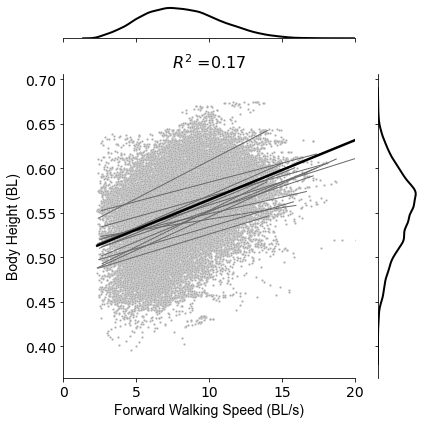

In [10]:
plot_metric = body_height_dist
ylabel_name = 'Body Height (BL)'
fig_name = 'body_height'
p_coeff = 1
plot_scatter = True
plot_1D_metrics_marginal_dists(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter)

#### Probability of number of legs in stance

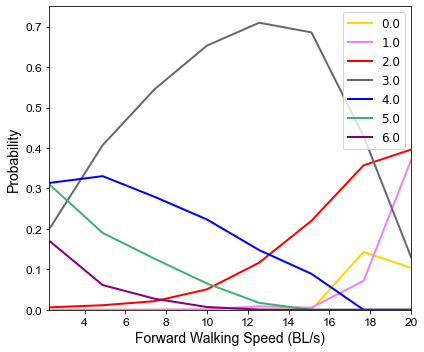

In [11]:
speed_dist = parallel_vel.flatten()
nlegs_dist = nlegs_stance_walking.flatten()

beh_ids = beh_class.flatten()

# isolate forward walking
fw_nlegs = nlegs_dist[beh_ids==1]
fw_vel = speed_dist[beh_ids==1]

# filter nlegs - remove nans
fw_vel = fw_vel[~np.isnan(fw_nlegs)]
fw_nlegs = fw_nlegs[~np.isnan(fw_nlegs)]


# edges of distributions
vel_bins =9
vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
nleg_cat = np.unique(fw_nlegs)

# compute probability distribution for each of the nleg categories
nleg_prob = np.zeros((len(nleg_cat), len(vel_center)))
for j in range(len(nleg_cat)):
    leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
    for i in range(len(vel_center)):
        nleg_vels = fw_vel[leg_idxs]
        nleg_prob[j,i] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
        
nleg_prob = nleg_prob/np.sum(nleg_prob, axis = 0)


# plot the probability of a certain number of legs in stance
fig = plt.figure(1, figsize = [6,5])
# plt.style.use('ggplot')
plt_colors = ['gold', 'violet', 'red', 'dimgray', 'blue', 'mediumseagreen', 'purple']
for j in range(nleg_prob.shape[0]):
    plt.plot(vel_center, nleg_prob[j,:], linewidth =2, color = plt_colors[j])

# axis properties
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xlabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
plt.xlim([2.25, 20])
plt.ylim([0, 0.75])

plt.legend(nleg_cat.astype(str), fontsize =12)
plt.grid(False)
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'nleg_stance_prob'+'.png', dpi = 200)
fig.savefig(figure_dir + 'nleg_stance_prob'+'.pdf', dpi = 200)

### Speed-dependent intralimb kinematics

- scatter plots with fits - combine leg pairs on the same plot

- only focus on forward walking bouts

In [12]:
def intralimb_kinematic_distrbutions(metric, w_vel, n_step_threshold):

    # iterate through legs 
    leg_dists = [] # front, middle, hind
    for leg in range(3):
        dist_cnt = 0
        for fly in np.unique(meta_matrix[:, 0]).astype(int).tolist():#:[0:10]:
            trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]

            # extract data
            vel_data = w_vel[trial_idxs,:].flatten()
            leg1_data = metric[leg, :, trial_idxs].flatten() # doesn't need to be transposed
            leg2_data = metric[leg+3, :, trial_idxs].flatten()

            # behavior classifier
            beh_ids = beh_class[trial_idxs, :].flatten()

            # filter for forward walking behavior == 1
            fw_vel_data = vel_data[beh_ids==1]
            fw_leg1_data = leg1_data[beh_ids==1]
            fw_leg2_data = leg2_data[beh_ids==1]

            # concatenate data
            cat_vel = np.concatenate((fw_vel_data, fw_vel_data))
            cat_data = np.concatenate((fw_leg1_data, fw_leg2_data))

            # filter concatenated data to remove Nans
            filter_vels = cat_vel[~np.isnan(cat_data)]
            filter_data  = cat_data[~np.isnan(cat_data)]

            # filter out -1 values
            filter_vels = filter_vels[~(filter_data ==-1)]
            filter_data = filter_data[~(filter_data ==-1)]

            # if there are a sufficient number of steps then store data as a distribution
            if len(filter_data) >= n_step_threshold:
                if dist_cnt == 0:
                    data_dist = filter_data
                    vel_dist = filter_vels
                    fly_dist = fly*np.ones(len(filter_data))
                    dist_cnt = 1
                else:
                    data_dist = np.concatenate((data_dist, filter_data))
                    vel_dist = np.concatenate((vel_dist, filter_vels))
                    fly_dist = np.concatenate((fly_dist, fly*np.ones(len(filter_data))))

        # stack data
        all_data = np.vstack((fly_dist, vel_dist, data_dist))
        leg_dists.append(all_data)
    
    return leg_dists   

In [13]:
# compute distributions for intralimb kinematics
# filtering parameters
n_step_threshold = 15 # need at least 15 steps from a fly

step_freq_distributions = intralimb_kinematic_distrbutions(step_freq, parallel_vel, n_step_threshold)
stance_duration_distributions = intralimb_kinematic_distrbutions(stance_duration, parallel_vel, n_step_threshold)
swing_duration_distributions = intralimb_kinematic_distrbutions(swing_duration, parallel_vel, n_step_threshold)
step_distance_distributions = intralimb_kinematic_distrbutions(step_distance, parallel_vel, n_step_threshold)

#### Plot Intralimb kinematics

In [14]:
def plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim):
    # plot parameters
    leg_colors = ['red', 'gold', 'blue']
    fly_colors = ['salmon', 'khaki','steelblue']

    # plot 1D metrics
    g = sea.JointGrid()

    for leg in range(3):
        vel_fit = np.linspace(np.min(plot_metric[leg][1,:]), np.max(plot_metric[leg][1,:]), 100)
        p = np.polyfit(plot_metric[leg][1,:], plot_metric[leg][2,:], p_coeff) # estimated coefficents...least squares polynomial fit
        y_fit = np.polyval(p, vel_fit)
        sea.lineplot(x=vel_fit, y=y_fit, color = leg_colors[leg], linewidth = 2.5, alpha =1, ax=g.ax_joint)

    # scatter
    if plot_scatter:
        for leg in range(3):
            sea.scatterplot(x=plot_metric[leg][1,:], y=plot_metric[leg][2,:], color = leg_colors[leg], s = 5, alpha = 0.5, ax=g.ax_joint)

    # plot for each fly 
    for leg in range(3):
        unique_flies = np.unique(plot_metric[leg][0,:]).tolist()#[0:10]
        for fly in unique_flies:
            fly_idxs = np.where(plot_metric[leg][0,:]==fly)[0] 
            vel_fit = np.linspace(np.min(plot_metric[leg][1,fly_idxs]), np.max(plot_metric[leg][1,fly_idxs]), 100)
            p = np.polyfit(plot_metric[leg][1,fly_idxs], plot_metric[leg][2,fly_idxs], p_coeff) # estimated coefficents...least squares polynomial fit
            y_fit = np.polyval(p, vel_fit)
            sea.lineplot(x=vel_fit, y=y_fit, color = fly_colors[leg], linewidth = 1, alpha =0.8, ax=g.ax_joint)

    # global fits
    n_steps = np.zeros(3)
    r2_vals = np.zeros(3)
    for leg in range(3):
        n_steps[leg] = len(plot_metric[leg][1,:])
        vel_fit = np.linspace(np.min(plot_metric[leg][1,:]), np.max(plot_metric[leg][1,:]), 100)
        p = np.polyfit(plot_metric[leg][1,:], plot_metric[leg][2,:], p_coeff) # estimated coefficents...least squares polynomial fit
        y_fit = np.polyval(p, vel_fit)
        r2_vals[leg] = np.around(r2_score(plot_metric[leg][2,:], np.polyval(p, plot_metric[leg][1,:])),2)
        sea.lineplot(x=vel_fit, y=y_fit, color = leg_colors[leg], linewidth = 2.5, alpha =1, ax=g.ax_joint)

    # kde propability - speed and metric
    for leg in range(3):
        sea.kdeplot(x=plot_metric[leg][1,:], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_x, alpha = 0.5)
        sea.kdeplot(y=plot_metric[leg][2,:], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_y, alpha = 0.5)


    # legend and plotting parameters
    legend_text = ['Front Legs (steps = '+str(int(n_steps[0]))+', $R^{2}$ ='+ str(r2_vals[0]) + ')', 'Middle Legs (steps = '+str(int(n_steps[1]))+', $R^{2}$ ='+ str(r2_vals[1]) + ')', 'Hind Legs (steps = '+str(int(n_steps[2]))+', $R^{2}$ ='+ str(r2_vals[2]) + ')']
    g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)

    g.ax_joint.set_xlim([0,20])
    g.ax_joint.set_ylim([ylim[0],ylim[1]])
    plt.tight_layout()
    plt.show()

    g.savefig(figure_dir + fig_name+'.png', dpi = 200)
    g.savefig(figure_dir + fig_name+'.pdf', dpi = 200)

C:\Users\pratt\AppData\Local\Temp\ipykernel_24424\1333664506.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


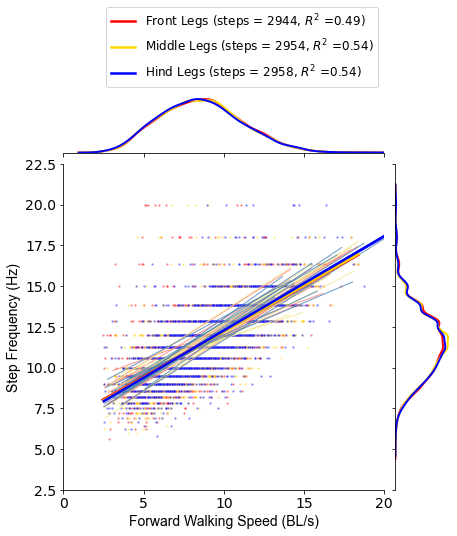

In [15]:
# plot_metric = step_freq_distributions
plot_metric = step_freq_distributions
ylabel_name = 'Step Frequency (Hz)'
fig_name = 'Step_freq'
p_coeff = 1
plot_scatter = True
ylim = [2.5,22.5]
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim)

C:\Users\pratt\AppData\Local\Temp\ipykernel_26332\1333664506.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


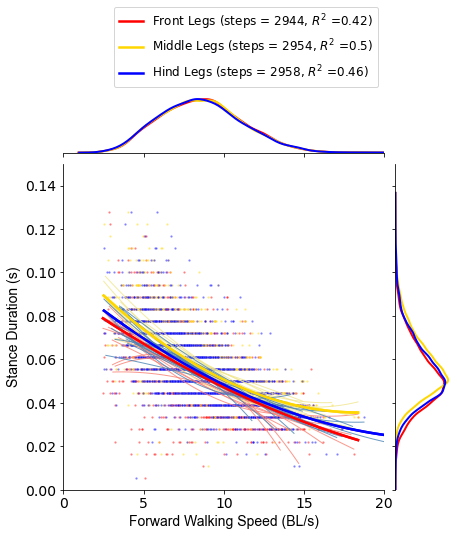

In [45]:
# plot_metric = step_freq_distributions
plot_metric = stance_duration_distributions
ylabel_name = 'Stance Duration (s)'
fig_name = 'Stance_duration'
p_coeff = 2
plot_scatter = True
ylim = [0, 0.15]
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim)

C:\Users\pratt\AppData\Local\Temp\ipykernel_26332\1333664506.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


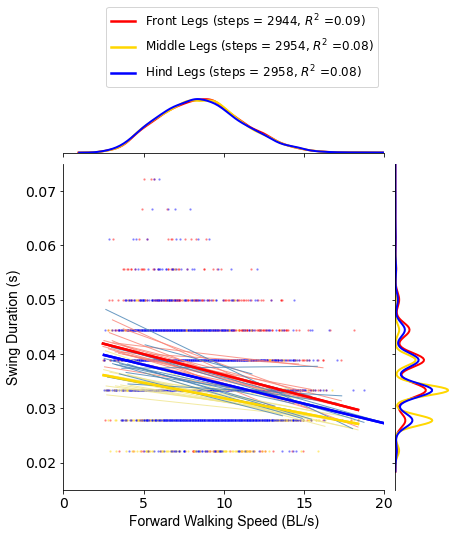

In [49]:
# plot_metric = step_freq_distributions
plot_metric = swing_duration_distributions
ylabel_name = 'Swing Duration (s)'
fig_name = 'Swing_duration'
p_coeff = 1
plot_scatter = True
ylim = [0.015, 0.075]
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim)

C:\Users\pratt\AppData\Local\Temp\ipykernel_26332\1333664506.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


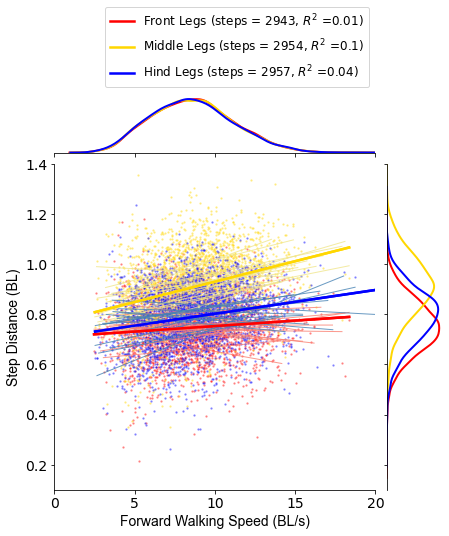

In [67]:
plot_metric = step_distance_distributions
ylabel_name = 'Step Distance (BL)'
fig_name = 'step_distance'
p_coeff = 1
plot_scatter = True
ylim = [0.1, 1.4]
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim)

### Inter-leg Coordination

In [68]:
# calculate mean of polar distributions by transforming them into cartesian coordinates then back to polar coordinates
def estimate_ang_stats(var):
#     mean_angle = np.arctan2(np.nanmedian(np.sin(var)), np.nanmedian(np.cos(var)))
    mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
    angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
    return mean_angle, angular_dispersion

In [69]:
def compute_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(0.0,2*np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 


In [70]:
# transform phase values to between -np.pi to np.pi
def transform_half_polar(var):
    var[var>np.pi] = var[var>np.pi] - (2*np.pi)
    return var

In [71]:
def full_distribution_transform_polar(var):
    var[var<0] = np.pi + np.abs(-np.pi - var[var<0])
    return var

In [72]:
def compute_inphase_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(-np.pi, np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

In [73]:
# function that transforms that space from 0 to pi to 0 to 2pi
def transform_polar(org_val):
    if org_val < 0: # only need to transform negative values to extend the space to 2pi
        transformed_val = np.pi + np.abs(-np.pi - org_val)
    else: 
        transformed_val = org_val
        
    return transformed_val

In [74]:
# relative phase distributions - to L1
relative_leg = [3, 3, 3, 3, 3] # L1-R1, L1-R2, L1-R3, L1-L2, L1-L3
inphase_comparasions = [1,4]
step_threshold = 10 # empirically determined
Nbins = 15
flies = np.unique(meta_matrix[:, 0]).astype(int).tolist()#[0:10]
fly_phase_stats = np.zeros((len(flies), 2, len(relative_leg), 3)) # flies, phase/max_prob, phase comparasion, slow/intermediate/fast
phase_dists = np.zeros((len(relative_leg), Nbins, 2, 3)) # phases, bins, prob/centers, slow/intermediate/fast
full_phase_dist = []

# iterate through phase comparasions
for p in range(len(relative_leg)):
    for fly in flies:
        trial_idxs = np.where(meta_matrix[:, 0] == fly)[0]
        vel_data = parallel_vel[trial_idxs,:].flatten()
        phase_data = phase[p, :, trial_idxs].flatten()
        beh_ids = beh_class[trial_idxs, :].flatten()
        
        # forward walking data
        fw_vel_data = vel_data[beh_ids==1]
        fw_phase_data = phase_data[beh_ids==1]
        
        # filter data - remove negative 1 and nan values
        filt_vel = fw_vel_data[fw_phase_data != -1]
        filt_phase = fw_phase_data[fw_phase_data != -1]
        
        filt_vel = filt_vel[~np.isnan(filt_phase)]
        filt_phase = filt_phase[~np.isnan(filt_phase)]
        
        # split phase into the different walking speed categories - rescale from 0-1 to 0-2pi
        slow_phase = filt_phase[filt_vel<6]*(2*np.pi)
        intermediate_phase = filt_phase[np.logical_and(filt_vel>=6, filt_vel<=10)]*(2*np.pi)
        fast_phase = filt_phase[filt_vel>10]*(2*np.pi)
        
        # compute fly specific stats
        '''slow'''
        if len(slow_phase) > step_threshold:
            slow_mean, _ = estimate_ang_stats(slow_phase)
            if p in inphase_comparasions:
                fly_phase_stats[fly-1, 0, p, 0] = slow_mean
                
                # distribution
                fly_slow_dist = transform_half_polar(slow_phase)
                slow_prob, slow_bin_centers = compute_inphase_histogram(fly_slow_dist, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(slow_bin_centers, slow_prob)
                fly_phase_stats[fly-1, 1, p, 0] =  f(slow_mean)
                
            else:
                fly_phase_stats[fly-1, 0, p, 0] = transform_polar(slow_mean)
                
                # distribution
                slow_prob, slow_bin_centers = compute_histogram(slow_phase, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(slow_bin_centers, slow_prob)
                fly_phase_stats[fly-1, 1, p, 0] =  f(transform_polar(slow_mean))
                
        '''intermediate'''
        if len(intermediate_phase) > step_threshold:
            intermediate_mean, _ = estimate_ang_stats(intermediate_phase)
            if p in inphase_comparasions:
                fly_phase_stats[fly-1, 0, p, 1] = intermediate_mean
                
                # distribution
                fly_intermediate_dist = transform_half_polar(intermediate_phase)
                intermediate_prob, intermediate_bin_centers = compute_inphase_histogram(fly_intermediate_dist, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(intermediate_bin_centers, intermediate_prob)
                fly_phase_stats[fly-1, 1, p, 1] =  f(intermediate_mean)
                
            else:
                fly_phase_stats[fly-1, 0, p, 1] = transform_polar(intermediate_mean)
                
                # distribution
                intermediate_prob, intermediate_bin_centers = compute_histogram(intermediate_phase, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(intermediate_bin_centers, intermediate_prob)
                fly_phase_stats[fly-1, 1, p, 1] =  f(transform_polar(intermediate_mean))
                
        '''fast'''
        if len(fast_phase) > step_threshold:
            fast_mean, _ = estimate_ang_stats(fast_phase)
            if p in inphase_comparasions:
                fly_phase_stats[fly-1, 0, p, 2] = fast_mean
                
                # distribution
                fly_fast_dist = transform_half_polar(fast_phase)
                fast_prob, fast_bin_centers = compute_inphase_histogram(fly_fast_dist, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(fast_bin_centers, fast_prob)
                fly_phase_stats[fly-1, 1, p, 2] =  f(fast_mean)
                
            else:
                fly_phase_stats[fly-1, 0, p, 2] = transform_polar(fast_mean)
                
                # distribution
                fast_prob, fast_bin_centers = compute_histogram(fast_phase, Nbins)
                
                # interpolate between these values to determine the probability at average phase
                f = interpolate.interp1d(fast_bin_centers, fast_prob)
                fly_phase_stats[fly-1, 1, p, 2] =  f(transform_polar(fast_mean))
                
                
        # Concatenate distributions
        if fly == 1:
            if p in inphase_comparasions:
                cat_slow = transform_half_polar(slow_phase)
                cat_intermediate = transform_half_polar(intermediate_phase)
                cat_fast = transform_half_polar(fast_phase)
            else:
                cat_slow = slow_phase
                cat_intermediate = intermediate_phase
                cat_fast = fast_phase
        else:
            if p in inphase_comparasions:
                cat_slow = np.concatenate((cat_slow, transform_half_polar(slow_phase)))
                cat_intermediate = np.concatenate((cat_intermediate, transform_half_polar(intermediate_phase)))
                cat_fast = np.concatenate((cat_fast, transform_half_polar(fast_phase)))
            else:
                cat_slow = np.concatenate((cat_slow, slow_phase))
                cat_intermediate = np.concatenate((cat_intermediate, intermediate_phase))
                cat_fast = np.concatenate((cat_fast, fast_phase))
                
    # compute distrbutions
    if p in inphase_comparasions:
        slow_prob_global, slow_bin_centers_global = compute_inphase_histogram(cat_slow, Nbins)
        intermediate_prob_global, intermediate_bin_centers_global = compute_inphase_histogram(cat_intermediate, Nbins)
        fast_prob_global, fast_bin_centers_global = compute_inphase_histogram(cat_fast, Nbins)
    else:
        slow_prob_global, slow_bin_centers_global = compute_histogram(cat_slow, Nbins)
        intermediate_prob_global, intermediate_bin_centers_global = compute_histogram(cat_intermediate, Nbins)
        fast_prob_global, fast_bin_centers_global = compute_histogram(cat_fast, Nbins)
        
    phase_dists[p,:,0,0] = slow_prob_global # phases, bins, prob/centers, slow/intermediate/fast
    phase_dists[p,:,1,0] = slow_bin_centers_global
    phase_dists[p,:,0,1] = intermediate_prob_global
    phase_dists[p,:,1,1] = intermediate_bin_centers_global
    phase_dists[p,:,0,2] = fast_prob_global
    phase_dists[p,:,1,2] = fast_bin_centers_global
    
    # store full phase distributions
    full_phase_dist.append([cat_slow, cat_intermediate, cat_fast])
    



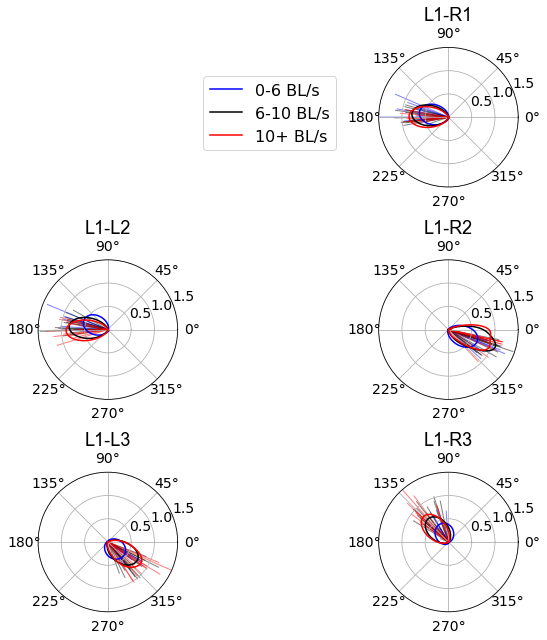

In [76]:
# plot relative phase to L1 - histograms
compare_labels = ['L1-R1', 'L1-R2', 'L1-R3','L1-L2', 'L1-L3']
plt_colors = ['blue', 'black', 'red']
fly_colors =['blue', 'black', 'red'] #['steelblue', 'silver', 'salmon']
plt_axes = [[0,1],[1,1],[2,1],[1,0],[2,0]]
speed_labels = ['0-6 BL/s', '6-10 BL/s', '10+ BL/s']

fig, axs = plt.subplots(3,2, figsize =[8,9], sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
for p in range(phase_dists.shape[0]):
    for j in range(3): # walking speed bins
                
        for fly in range(fly_phase_stats.shape[0]):
            axs[plt_axes[p][0], plt_axes[p][1]].plot(np.array([0, fly_phase_stats[fly,0,p,j]]), np.array([0, fly_phase_stats[fly,1,p,j]]), color = fly_colors[j], linewidth = 1, zorder=1, alpha = 0.5)
        
        # plot distribution
        sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=full_phase_dist[p][j], color = plt_colors[j], linewidth = 1.5, zorder=10, label = speed_labels[j], bw_adjust=2) 
        
    # plot parameters
    axs[plt_axes[p][0], plt_axes[p][1]].tick_params(axis='both', labelsize=14)
    axs[plt_axes[p][0], plt_axes[p][1]].set_ylabel(None)
    axs[plt_axes[p][0], plt_axes[p][1]].set_title(compare_labels[p], fontsize=18, fontname="Arial")
    axs[plt_axes[p][0], plt_axes[p][1]].set_ylim([0,1.5])
    
    if p ==0:
        axs[plt_axes[p][0], plt_axes[p][1]].legend(fontsize = 16, bbox_to_anchor=(-0.25, 0.85))
        
axs[0,0].axis('off')
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.png', dpi = 200)
fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.pdf', dpi = 200)